In [1]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
#from torchvision.utils import save_image
#from tqdm import tqdm

#from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
#import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
SEED=42

In [4]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [5]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [6]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

In [7]:
img_shape=tuple(l.data[0].shape)
img_dim=mul(*img_shape)
img_shape,img_dim

((28, 28), 784)

In [8]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [9]:
IMG_DTYPE=np.float32

#training set
yl=y_l #get selected imgs
xl=x_l.astype(IMG_DTYPE)/255 #color 0~255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

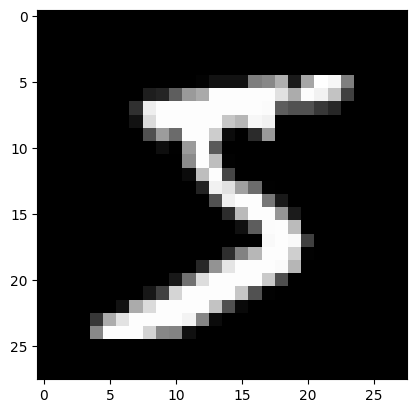

In [10]:
plt.imshow(xl[0], cmap='gray') 

In [11]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [12]:
Z_DIM=16
MID_DIM=256
num_tags=len(set(yl))

class VAE(nn.Module):
    def __init__(self,z_dim=Z_DIM,mid_dim=MID_DIM,num_tags=num_tags):
        super().__init__()
        self.fc1 = nn.Linear(img_dim, mid_dim)
        
        self.fc21 = nn.Linear(mid_dim,z_dim) #mu (mean)
        self.fc22 = nn.Linear(mid_dim, z_dim) #sigma (std)


        self.fc3 = nn.Linear(z_dim, mid_dim)
        self.fc4 = nn.Linear(mid_dim,img_dim)

        self.mu_shift = nn.Embedding(num_tags, z_dim)
        self.log_std_shift = nn.Embedding(num_tags, z_dim)
        
    def encode(self,x):
        x=torch.relu(self.fc1(x))
        return self.fc21(x),self.fc22(x)

    def decode(self,z):
        return F.sigmoid(
            self.fc4(
                torch.relu(
                    self.fc3(
                        z
                    )
                )
            )
        )
    
    def gen(self,tag,e=0):
        return self.decode(
            self.mu_shift(tag)+e*(torch.exp(self.log_std_shift(tag)*0.5)+1)
        )



    def forward(self, x, tag):
        mu, log_std = self.encode(
            x.view(-1, img_dim)
        )
        std=torch.exp(log_std*0.5)
        z=self.mu_shift(tag)+mu+(torch.exp(self.log_std_shift(tag)*0.5)+std)*torch.randn_like(std)
        return self.decode(z),mu,std,log_std

In [13]:
def loss_fn(x, y, mu, std, log_std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') + \
        torch.sum(1 + log_std - mu**2 - std**2)* -0.5*2

In [14]:
torch.manual_seed(SEED)
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [15]:
I=torch.eye(Z_DIM).to(device)*99

In [16]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,tag) in enumerate(dl):
            
            x,tag=x.to(device),tag.to(device)
            #print(type(tag))

            # 1. Forward pass
            y,mu,std,log_std = model(x,tag)

            # 2. Caculate the loss
            loss=loss_fn(x,y,mu,std,log_std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%10==0:
            print(epoch_loss)
            
    model.eval()


In [17]:
torch.manual_seed(SEED)
l_step(
    model,
    ld,
    loss_fn,
    op,
    50
)

10449996.697265625
7472250.816894531
7299124.854248047
7229865.178466797
7192822.0498046875


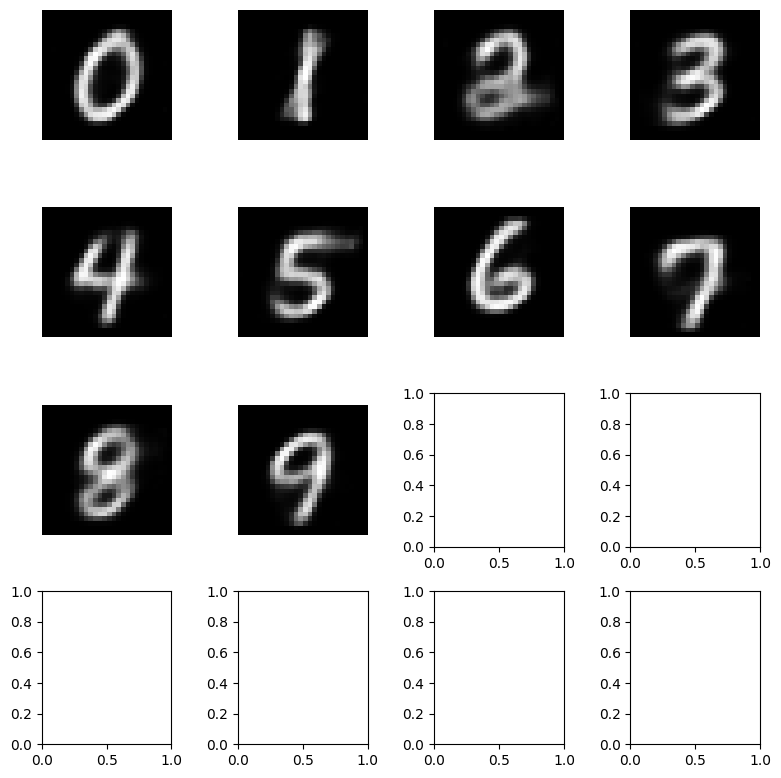

In [18]:
"""
sample at mu (stuff after 9 should not carry any meaning)
"""
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Loop through the axes and images
for i,ax in zip(range(num_tags),axes.ravel()):
    ax.imshow(model.gen(torch.Tensor([i]).long().to(device)).cpu().view(*img_shape).detach().numpy(), cmap='gray')  # Display each image
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [26]:
for i in range(num_tags):
    for j in range(num_tags):
        print(
            torch.sum(
                (
                    model.mu_shift(torch.Tensor([i]).long().to(device)).cpu().detach() - \
                    model.mu_shift(torch.Tensor([j]).long().to(device)).cpu().detach()
                )**2
            )
    )

tensor(0.)
tensor(338.5215)
tensor(219.2328)
tensor(251.0930)
tensor(266.7531)
tensor(203.7656)
tensor(241.7224)
tensor(181.9446)
tensor(213.3384)
tensor(119.2207)
tensor(338.5215)
tensor(0.)
tensor(325.6856)
tensor(359.5926)
tensor(197.6520)
tensor(438.9837)
tensor(428.5462)
tensor(375.3323)
tensor(320.3834)
tensor(358.0179)
tensor(219.2328)
tensor(325.6856)
tensor(0.)
tensor(233.2376)
tensor(255.9011)
tensor(191.8485)
tensor(339.2549)
tensor(189.2201)
tensor(172.3585)
tensor(214.0398)
tensor(251.0930)
tensor(359.5926)
tensor(233.2376)
tensor(0.)
tensor(328.6338)
tensor(177.4989)
tensor(268.1172)
tensor(253.0499)
tensor(202.4375)
tensor(187.0401)
tensor(266.7531)
tensor(197.6520)
tensor(255.9011)
tensor(328.6338)
tensor(0.)
tensor(322.9859)
tensor(253.9064)
tensor(180.0219)
tensor(302.2675)
tensor(160.5316)
tensor(203.7656)
tensor(438.9837)
tensor(191.8485)
tensor(177.4989)
tensor(322.9859)
tensor(0.)
tensor(186.5922)
tensor(313.3922)
tensor(199.7206)
tensor(276.9306)
tensor(241.7224)

In [27]:
#torch.exp(self.log_std_shift(tag)*0.5)
for i in range(num_tags):
    for j in range(num_tags):
        print(
            torch.sum(
                (
                    torch.exp(model.log_std_shift(torch.Tensor([i]).long().to(device))*0.5).cpu().detach() - \
                    torch.exp(model.log_std_shift(torch.Tensor([j]).long().to(device))*0.5).cpu().detach()
                )**2
            )
    )

tensor(0.)
tensor(2.2492e-11)
tensor(1.9874e-12)
tensor(7.2397e-13)
tensor(1.2579e-12)
tensor(1.7153e-12)
tensor(2.1249e-12)
tensor(5.5198e-12)
tensor(2.6613e-12)
tensor(1.1621e-12)
tensor(2.2492e-11)
tensor(0.)
tensor(2.2243e-11)
tensor(2.7722e-11)
tensor(2.5269e-11)
tensor(1.6589e-11)
tensor(2.1802e-11)
tensor(1.0836e-11)
tensor(1.3801e-11)
tensor(2.5434e-11)
tensor(1.9874e-12)
tensor(2.2243e-11)
tensor(0.)
tensor(1.5384e-12)
tensor(1.5998e-12)
tensor(1.2972e-12)
tensor(3.2799e-12)
tensor(3.1448e-12)
tensor(1.5415e-12)
tensor(1.9455e-12)
tensor(7.2397e-13)
tensor(2.7722e-11)
tensor(1.5384e-12)
tensor(0.)
tensor(5.4552e-13)
tensor(3.1244e-12)
tensor(2.4111e-12)
tensor(7.3504e-12)
tensor(3.8809e-12)
tensor(7.8969e-13)
tensor(1.2579e-12)
tensor(2.5269e-11)
tensor(1.5998e-12)
tensor(5.4552e-13)
tensor(0.)
tensor(3.5013e-12)
tensor(1.4515e-12)
tensor(6.9496e-12)
tensor(3.9467e-12)
tensor(2.0052e-13)
tensor(1.7153e-12)
tensor(1.6589e-11)
tensor(1.2972e-12)
tensor(3.1244e-12)
tensor(3.5013e

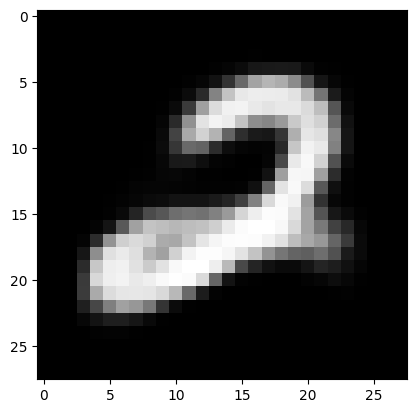

In [71]:
plt.imshow(model.gen(
    torch.Tensor([2]).long().to(device),torch.normal(0,1,size=(1,Z_DIM)).to(device)
).cpu().view(*img_shape).detach().numpy(), cmap='gray') 